In [30]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [32]:
def f(x):
    return 3*x**2 - 4*x + 5

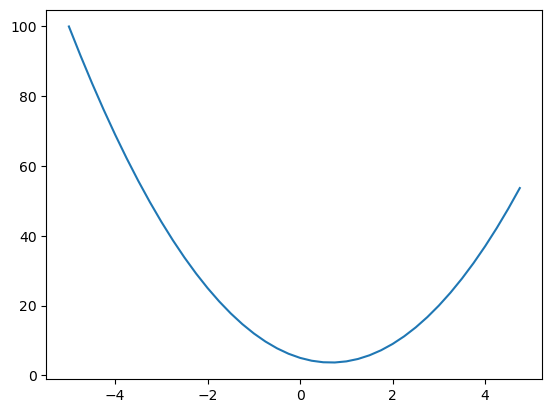

In [34]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [36]:
h = 0.00000000000001
x = -3.0
f(x+h)

43.99999999999978

In [38]:
(f(x+h) - f(x)) / h

-22.026824808563106

In [40]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c

def d(a, b, c):
    return a * b + c

d_1 = d(a, b, c)
a += h 
d_2 = d(a, b, c)

print((d_2 - d_1)  / h)

-3.019806626980426


In [232]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward =_backward
        
        return out
        
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other**-1)
            
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
                    
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            # local derivate of d(e^x)/dx == e^x == out.data
            self.grad += out.data * out.grad
        out._backward = _backward
            
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()    
    
a = Value(2.0, label='a')
b = Value (-3.0, label='b')
c = Value (10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'l'

In [234]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

In [236]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(
        format="svg", 
        graph_attr={
            "rankdir": "LR"
        }
    )
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record"
        )
        
        if n._op:
            dot.node(
                name=uid + n._op,
                label=n._op
            )
            
            dot.edge(
                uid + n._op,
                uid
            )
            
    for n1, n2 in edges:
        dot.edge(
            str(id(n1)),
            str(id(n2)) + n2._op
        )
    
    return dot

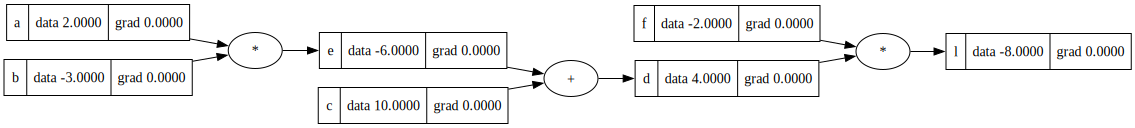

In [238]:
draw_dot(L)

In [240]:
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [242]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

In [244]:
e = a * b
d = e + c
L = d * f

print(L.data)

-35.549696


In [246]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value (-3.0, label='b')
    c = Value (10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'l'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value (-3.0, label='b')
    c = Value (10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'l'
    L2 = L.data
    
    print((L2 - L1) / h)
        
lol()

0.0


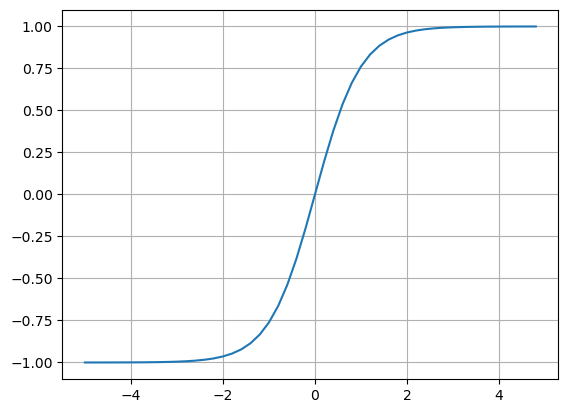

In [248]:
xs = np.arange(-5, 5, 0.2)
               
plt.plot(
    xs,
    np.tanh(xs)
)

plt.grid()

In [250]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

In [252]:
o.grad = 1.0

o._backward()

n._backward()

b._backward()

x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()

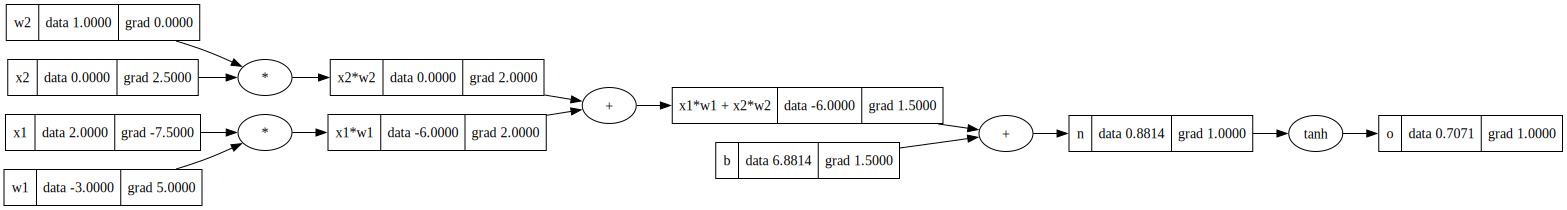

In [254]:
draw_dot(o)

In [256]:
o.grad = 1
# n.grad = 1 - tanh(n) ** 2
n.grad = 1 - o.data ** 2

b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

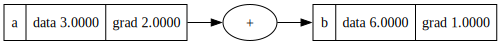

In [258]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

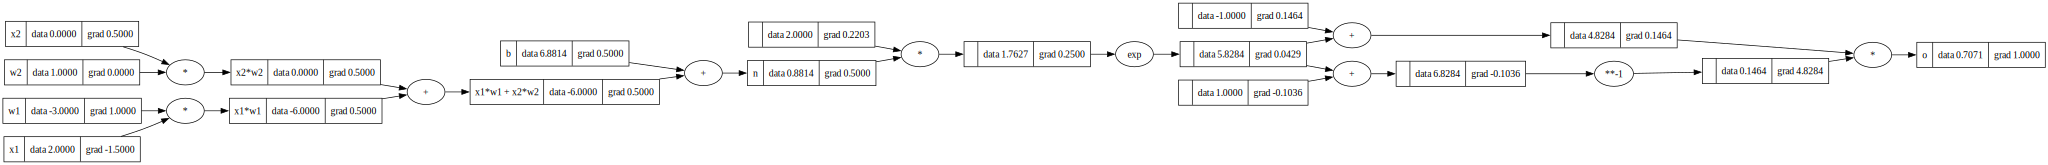

In [260]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

o.backward()
draw_dot(o)

In [262]:
import torch

In [264]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [549]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if (len(outs) == 1) else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
loss.backward()

learning_rate = 0.01

for p in n.parameters():
    p.data += learning_rate * -p.grad

loss = sum([(y_hat - y_true) ** 2 for y_true, y_hat in zip(ys, ypred)])

loss

In [571]:
x = [2.0, 3.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.36641680040126795)

In [581]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9695081975767179),
 Value(data=-0.9296024747946157),
 Value(data=-0.9087188374923943),
 Value(data=0.9123453920423704)]

In [577]:
learning_rate = 0.01
num_steps = 100

for k in range(num_steps):
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum((y_hat - y_true) ** 2 for y_true, y_hat in zip(ys, y_pred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += learning_rate * -p.grad

    print(k, loss.data)

0 0.059202152293462706
1 0.058252522527107636
2 0.057331461999572335
3 0.05643773657035803
4 0.055570180757638
5 0.054727693103420766
6 0.05390923190433876
7 0.05311381127522209
8 0.052340497515909024
9 0.05158840575468085
10 0.05085669684431653
11 0.05014457448909301
12 0.04945128258313748
13 0.048776102742395466
14 0.04811835201414713
15 0.04747738074949495
16 0.04685257062558543
17 0.04624333280553247
18 0.04564910622509402
19 0.0450693559961254
20 0.04450357191771813
21 0.04395126708672006
22 0.04341197660005619
23 0.04288525634191458
24 0.04237068184944946
25 0.04186784725118971
26 0.041376364272818045
27 0.04089586130543102
28 0.040425982531784074
29 0.03996638710639215
30 0.039516748385684024
31 0.03907675320471164
32 0.038646101197190696
33 0.038224504155896524
34 0.03781168543067366
35 0.03740737936152239
36 0.03701133074442095
37 0.036623294327715425
38 0.03624303433707271
39 0.03587032402713888
40 0.03550494525818027
41 0.03514668809611205
42 0.03479535043443063
43 0.0344507

In [583]:
ypred

[Value(data=0.9695081975767179),
 Value(data=-0.9296024747946157),
 Value(data=-0.9087188374923943),
 Value(data=0.9123453920423704)]

In [491]:
n.layers[0].neurons[0].w[0].grad

-1.6087008816695658

In [439]:
n.layers[0].neurons[0].w[0].data

0.07236922564741471

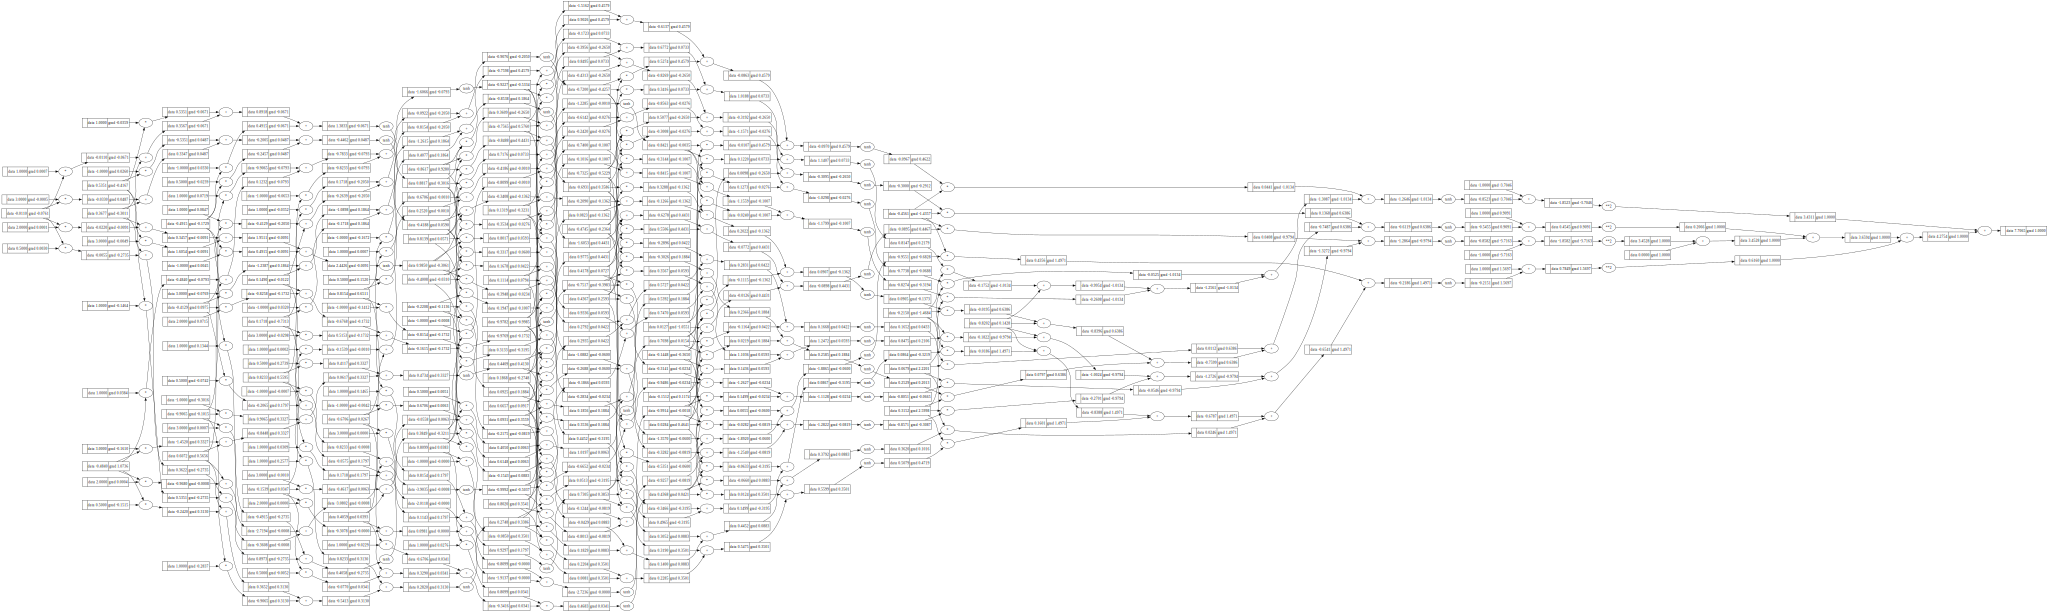

In [333]:
draw_dot(loss)

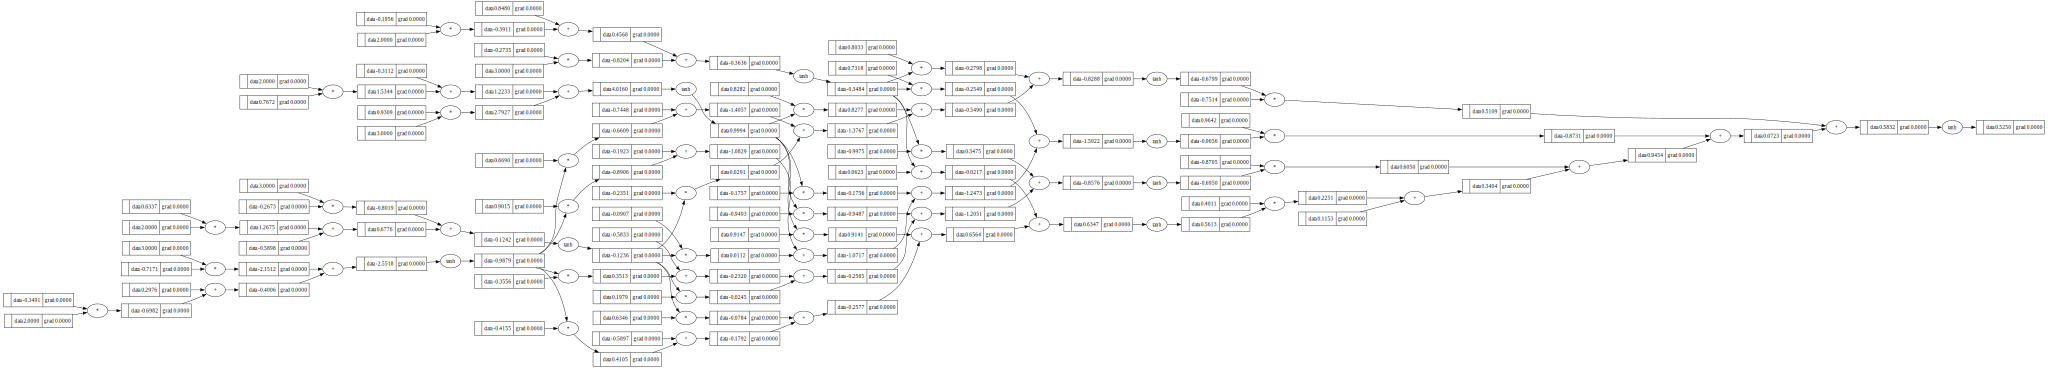

In [164]:
draw_dot(n(x))